In [1]:
# P. Barry Seavey
# PRED 454-55, Winter 2018
# project 2
# kaggle.com 'Facial Keypoints Detection'

In [2]:
# CNN model with augmented data (NaN imputed w/ model2 predictions)

In [3]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
from sklearn.utils import shuffle

In [5]:
import os
print(os.listdir('../Facial Keypoints'))

['.ipynb_checkpoints', '15_pt_1.PNG', '4 Traditional White with Purple.pptx', '4_pt_1.PNG', 'clean-white-brick-wall-textures-plain-820x532.jpg', 'CNN2_128-500-500-30_augmentdata.h5', 'CNN2_128-500-500-30_dropout.h5', 'CNN2_128-500-500-30_v1.h5', 'CNN_500-90-30_v2.h5', 'CNN_500-90-30_v5.h5', 'df_dump.PNG', 'face_model.h5', 'Fac_Kpt_1stCNNModel.ipynb', 'Fac_Kpt_1stModel.ipynb', 'Fac_Kpt_CNN-m2-flipnonull.ipynb', 'Fac_Kpt_CNN-model2-augmentdata.ipynb', 'Fac_Kpt_CNN-num2-dropout.ipynb', 'Fac_Kpt_CNN-num2.ipynb', 'Fac_Kpt_EDA1.ipynb', 'Fac_Kpt_img-extraction.ipynb', 'Fac_Kpt_nullpredict.ipynb', 'FKPt - imputedata1.ipynb', 'FKPt_CNN-batchnorm.ipynb', 'FKPt_CNN-m2-ensemble_augdata.ipynb', 'IdLookupTable.csv', 'imgs', 'KPT_500-90-30.h5', 'model2_augmentdata.csv', 'model2_flipnonull.csv', 'model2_v1.csv', 'model2_withdrop.csv', 'nigel.jpg', 'pic1.png', 'SampleSubmission.csv', 'Screen_Caps', 'Seavey_base_500-90-30_v2.csv', 'Seavey_base_500-90-30_v3.csv', 'Seavey_base_500-90-30_v4.csv', 'Seavey_f

In [6]:
#

In [7]:
FROOT = os.getcwd() # Path to your project folder
FTRAIN = FROOT + '/training_augmented.csv'
FTEST = FROOT + '/test.csv'
FLOOKUP = FROOT + '/IdLookupTable.csv'

In [8]:
def load(test = False, cols = None):
    """
    Loads the dataset.
    
    Parameters
    ----------
    test  : optional, defaults to `False`
            Flag indicating if we need to load from `FTEST` (`True`) or `FTRAIN` (`False`)
    cols  : optional, defaults to `None`
            A list of columns you're interested in. If specified only returns these columns.
               
    Returns
    -------
    A tuple of X and y, if `test` was set to `True` y contains `None`.    
    """
    
    fname = FTEST if test else FTRAIN
    df = pd.read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    #if cols:  # get a subset of columns
        #df = df[list(cols) + ['Image']]

    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them
    columns = df.columns

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=123)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y, columns

In [9]:
def plt_sample(num):
    img = X[num].reshape(96, 96)
    #
    plt.imshow(img, cmap='gray')
    plt.scatter(y[num][0::2] * 48 + 48, y[num][1::2] * 48 + 48, marker='x', s=10, color='red')

In [10]:
X, y, columns = load()  # loads train data only

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      4752
left_eye_inner_corner_y      4752
left_eye_outer_corner_x      4748
left_eye_outer_corner_y      4748
right_eye_inner_corner_x     4749
right_eye_inner_corner_y     4749
right_eye_outer_corner_x     4749
right_eye_outer_corner_y     4749
left_eyebrow_inner_end_x     4751
left_eyebrow_inner_end_y     4751
left_eyebrow_outer_end_x     4706
left_eyebrow_outer_end_y     4706
right_eyebrow_inner_end_x    4751
right_eyebrow_inner_end_y    4751
right_eyebrow_outer_end_x    4717
right_eyebrow_outer_end_y    4717
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          4750
mouth_left_corner_y          4750
mouth_right_corner_x         4751
mouth_right_corner_y         4751
mouth_center_top_lip_x       4756
mouth_center_top_lip_y       4756
mouth_center_bottom_lip_x    7023
mouth_center_b

In [11]:
columns = np.array(list(columns[:-1]))

In [12]:
X.shape

(4621, 9216)

In [13]:
y.shape

(4621, 30)

In [14]:
# Now try CNN & hope things don't bomb out

In [15]:
from keras.layers import Dense, Activation, MaxPool2D, Conv2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D,MaxPooling2D
from keras.models import Sequential, Model, model_from_json
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [16]:
X.shape

(4621, 9216)

In [17]:
X = X.reshape(-1,96,96, 1)

In [18]:
X.shape

(4621, 96, 96, 1)

In [19]:
y

array([[ 0.31135714, -0.24995001, -0.33985713, ...,  0.42725715,
         0.02894286,  0.63108569],
       [ 0.39154217, -0.19272289, -0.37304819, ...,  0.46956626,
         0.01463855,  0.70648193],
       [ 0.37710527, -0.21201342, -0.3164342 , ...,  0.48590994,
         0.05436842,  0.52272445],
       ..., 
       [ 0.40660843, -0.27268675, -0.37780121, ...,  0.52177709,
         0.02445783,  0.70950001],
       [ 0.3439562 , -0.19708247, -0.38539353, ...,  0.46793017,
         0.03137714,  0.63033146],
       [ 0.38568312, -0.25504577, -0.38986424, ...,  0.46909967,
         0.14705333,  0.59507334]], dtype=float32)

In [20]:
from keras.optimizers import SGD

In [21]:
def SimpleCNN(withDropout=False):

    model = Sequential()
    model.add(Conv2D(32,(3, 3), input_shape = (96, 96, 1)))
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size = (2,2))) 
    if withDropout:
        model.add(Dropout(0.1))
        
    model.add(Conv2D(64,(2,2)))
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size = (2,2)))
    if withDropout:
        model.add(Dropout(0.1))
    
    model.add(Conv2D(128,(2,2)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    if withDropout:
        model.add(Dropout(0.1))
        
    model.add(Flatten())
    
    model.add(Dense(500))
    model.add(Activation('relu'))
    if withDropout:
        model.add(Dropout(0.1))
        
    model.add(Dense(500))
    model.add(Activation('relu'))
    if withDropout:
        model.add(Dropout(0.1))
        
    model.add(Dense(30))
    sgd = SGD(lr=0.01, momentum = 0.9, nesterov=True)
    model.compile(loss='mse', optimizer=sgd, metrics=['accuracy'])
    return(model)

In [22]:
checkpointer = ModelCheckpoint(filepath='CNN2_128-500-500-30_augmentdata.h5', verbose=1, save_best_only=True)

In [23]:
%%time
model2 = SimpleCNN()

hist2 = model2.fit(X,y,epochs=200, validation_split=0.2, shuffle=True, verbose=1, callbacks=[checkpointer])

Train on 3696 samples, validate on 925 samples
Epoch 1/200
3696/3696 [==============================] - 53s - loss: 0.0205 - acc: 0.3552 - val_loss: 0.0061 - val_acc: 0.4162
Epoch 2/200
3696/3696 [==============================] - 52s - loss: 0.0055 - acc: 0.4578 - val_loss: 0.0054 - val_acc: 0.4368
Epoch 3/200
3696/3696 [==============================] - 52s - loss: 0.0050 - acc: 0.4708 - val_loss: 0.0050 - val_acc: 0.4681
Epoch 4/200
3696/3696 [==============================] - 52s - loss: 0.0048 - acc: 0.4735 - val_loss: 0.0049 - val_acc: 0.4432
Epoch 5/200
3696/3696 [==============================] - 52s - loss: 0.0047 - acc: 0.4802 - val_loss: 0.0048 - val_acc: 0.4411
Epoch 6/200
3696/3696 [==============================] - 52s - loss: 0.0046 - acc: 0.4773 - val_loss: 0.0047 - val_acc: 0.5200
Epoch 7/200
3696/3696 [==============================] - 53s - loss: 0.0045 - acc: 0.4797 - val_loss: 0.0047 - val_acc: 0.4941
Epoch 8/200
3696/3696 [==============================] - 53s - l

3696/3696 [==============================] - 53s - loss: 0.0043 - acc: 0.5170 - val_loss: 0.0045 - val_acc: 0.5146
Epoch 28/200
3696/3696 [==============================] - 52s - loss: 0.0043 - acc: 0.5211 - val_loss: 0.0044 - val_acc: 0.5654
Epoch 29/200
3696/3696 [==============================] - 52s - loss: 0.0043 - acc: 0.5268 - val_loss: 0.0044 - val_acc: 0.5297
Epoch 30/200
3696/3696 [==============================] - 52s - loss: 0.0043 - acc: 0.5276 - val_loss: 0.0044 - val_acc: 0.5178
Epoch 31/200
3696/3696 [==============================] - 52s - loss: 0.0042 - acc: 0.5344 - val_loss: 0.0044 - val_acc: 0.5341
Epoch 32/200
3696/3696 [==============================] - 52s - loss: 0.0042 - acc: 0.5373 - val_loss: 0.0044 - val_acc: 0.5211
Epoch 33/200
3696/3696 [==============================] - 52s - loss: 0.0042 - acc: 0.5376 - val_loss: 0.0044 - val_acc: 0.5751
Epoch 34/200
3696/3696 [==============================] - 52s - loss: 0.0042 - acc: 0.5409 - val_loss: 0.0044 - val_a

3696/3696 [==============================] - 52s - loss: 0.0034 - acc: 0.6442 - val_loss: 0.0036 - val_acc: 0.6216
Epoch 82/200
3696/3696 [==============================] - 52s - loss: 0.0034 - acc: 0.6458 - val_loss: 0.0036 - val_acc: 0.6476
Epoch 83/200
3696/3696 [==============================] - 52s - loss: 0.0034 - acc: 0.6529 - val_loss: 0.0036 - val_acc: 0.6551
Epoch 84/200
3696/3696 [==============================] - 52s - loss: 0.0033 - acc: 0.6526 - val_loss: 0.0036 - val_acc: 0.6476
Epoch 85/200
3696/3696 [==============================] - 52s - loss: 0.0033 - acc: 0.6510 - val_loss: 0.0036 - val_acc: 0.6476
Epoch 86/200
3696/3696 [==============================] - 52s - loss: 0.0033 - acc: 0.6531 - val_loss: 0.0036 - val_acc: 0.6238
Epoch 87/200
3696/3696 [==============================] - 52s - loss: 0.0033 - acc: 0.6569 - val_loss: 0.0036 - val_acc: 0.6454
Epoch 88/200
3696/3696 [==============================] - 52s - loss: 0.0033 - acc: 0.6537 - val_loss: 0.0035 - val_a

3696/3696 [==============================] - 52s - loss: 0.0029 - acc: 0.6788 - val_loss: 0.0032 - val_acc: 0.6768
Epoch 138/200
3696/3696 [==============================] - 52s - loss: 0.0029 - acc: 0.6775 - val_loss: 0.0032 - val_acc: 0.6757
Epoch 139/200
3696/3696 [==============================] - 52s - loss: 0.0029 - acc: 0.6807 - val_loss: 0.0032 - val_acc: 0.6768
Epoch 140/200
3696/3696 [==============================] - 52s - loss: 0.0029 - acc: 0.6751 - val_loss: 0.0032 - val_acc: 0.6822
Epoch 141/200
3696/3696 [==============================] - 52s - loss: 0.0029 - acc: 0.6824 - val_loss: 0.0032 - val_acc: 0.6843
Epoch 142/200
3696/3696 [==============================] - 52s - loss: 0.0029 - acc: 0.6813 - val_loss: 0.0032 - val_acc: 0.6832
Epoch 143/200
3696/3696 [==============================] - 52s - loss: 0.0029 - acc: 0.6761 - val_loss: 0.0032 - val_acc: 0.6811
Epoch 144/200
3696/3696 [==============================] - 52s - loss: 0.0029 - acc: 0.6786 - val_loss: 0.0032 

3696/3696 [==============================] - 52s - loss: 0.0028 - acc: 0.6902 - val_loss: 0.0031 - val_acc: 0.6811
Epoch 167/200
3696/3696 [==============================] - 52s - loss: 0.0028 - acc: 0.6867 - val_loss: 0.0031 - val_acc: 0.6865
Epoch 168/200
3696/3696 [==============================] - 52s - loss: 0.0028 - acc: 0.6924 - val_loss: 0.0031 - val_acc: 0.6800
Epoch 169/200
3696/3696 [==============================] - 52s - loss: 0.0027 - acc: 0.6891 - val_loss: 0.0031 - val_acc: 0.6832
Epoch 170/200
3696/3696 [==============================] - 52s - loss: 0.0027 - acc: 0.6905 - val_loss: 0.0031 - val_acc: 0.6832
Epoch 171/200
3696/3696 [==============================] - 53s - loss: 0.0027 - acc: 0.6878 - val_loss: 0.0031 - val_acc: 0.6822
Epoch 172/200
3696/3696 [==============================] - 52s - loss: 0.0027 - acc: 0.6918 - val_loss: 0.0032 - val_acc: 0.6865
Epoch 173/200
3696/3696 [==============================] - 53s - loss: 0.0027 - acc: 0.6891 - val_loss: 0.0031 

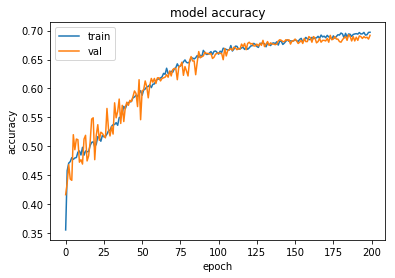

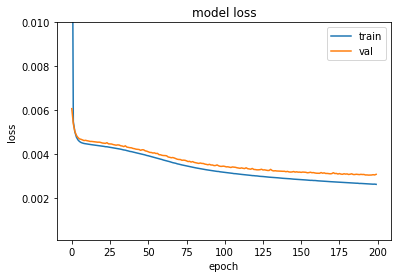

In [24]:
# summarize history for accuracy
plt.plot(hist2.history['acc'])
plt.plot(hist2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim(1e-4, 1e-2)
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [25]:
X_test, _, _ = load(test=True)

ImageId    1783
Image      1783
dtype: int64


In [26]:
X_test.shape

(1783, 9216)

In [27]:
X_test=X_test.reshape(-1, 96, 96, 1)

In [28]:
X_test.shape

(1783, 96, 96, 1)

In [29]:
#model.load_weights("CNN_500-90-30_v2.h5")
#y_test = model2.predict(X_test)
#print(y_test.shape)

In [30]:
y_pred2 = model2.predict(X_test)
landmark_nm = pd.read_csv(os.path.expanduser(FTRAIN)).columns[:-1].values
df_y_pred2 = pd.DataFrame(y_pred2,columns = landmark_nm)

In [31]:
df_y_pred2.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,0.405260,-0.243796,-0.377746,-0.258769,0.259630,-0.231955,0.540179,-0.234985,-0.259646,-0.224607,...,0.042154,0.051013,0.335355,0.548384,-0.314569,0.546269,-0.014029,0.407832,-0.003640,0.753280
1,0.421449,-0.246064,-0.416468,-0.229001,0.254229,-0.207222,0.551876,-0.221089,-0.259874,-0.227644,...,0.035219,0.244467,0.350563,0.595892,-0.293097,0.614048,0.025127,0.526901,0.020857,0.802338
2,0.351228,-0.228392,-0.336591,-0.205033,0.238423,-0.227649,0.479296,-0.251520,-0.254571,-0.203030,...,0.041212,0.155164,0.314079,0.551315,-0.227343,0.587820,0.039459,0.461823,0.066294,0.723397
3,0.378208,-0.205327,-0.374138,-0.156778,0.239418,-0.202658,0.522156,-0.195260,-0.231561,-0.179772,...,0.012630,0.167529,0.365246,0.581753,-0.289141,0.619350,0.019519,0.485785,0.035353,0.685305
4,0.400101,-0.230221,-0.415285,-0.210269,0.274195,-0.218995,0.540771,-0.215712,-0.276204,-0.208393,...,0.009923,0.141029,0.336019,0.605496,-0.290841,0.617619,0.014313,0.468863,0.000859,0.819280


In [32]:
y_pred2

array([[ 0.40525961, -0.24379641, -0.37774557, ...,  0.40783167,
        -0.00364013,  0.75327969],
       [ 0.42144868, -0.24606365, -0.41646805, ...,  0.52690095,
         0.02085679,  0.80233771],
       [ 0.3512277 , -0.22839189, -0.33659145, ...,  0.46182296,
         0.0662935 ,  0.72339743],
       ..., 
       [ 0.43124729, -0.15832986, -0.3419725 , ...,  0.55548841,
        -0.03583246,  0.59545535],
       [ 0.35892183, -0.22413433, -0.36535928, ...,  0.56359869,
        -0.06003534,  0.53456837],
       [ 0.38435057, -0.1776751 , -0.35053191, ...,  0.54250377,
        -0.04423153,  0.63493431]], dtype=float32)

In [33]:
IdLookup = pd.read_csv('../Facial Keypoints/IdLookupTable.csv')

def prepare_submission(y_pred,filename):

    ImageId = IdLookup["ImageId"]
    FeatureName = IdLookup["FeatureName"]
    RowId = IdLookup["RowId"]
    
    submit = []
    for rowId,irow,landmark in zip(RowId,ImageId,FeatureName):
        submit.append([rowId,df_y_pred2[landmark].iloc[irow-1]])
    
    submit = pd.DataFrame(submit,columns=["RowId","Location"])
    ## adjust the scale 
    submit["Location"] = submit["Location"]*48 + 48
    print(submit.shape)
    loc = "../Facial Keypoints/" + filename + ".csv"
    submit.to_csv(loc,index=False)
    print("File is saved at:" +  loc)
    
prepare_submission(y_pred2,"model2_augmentdata-v2")

(27124, 2)
File is saved at:../Facial Keypoints/model2_augmentdata-v2.csv


In [35]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10, color='yellow')

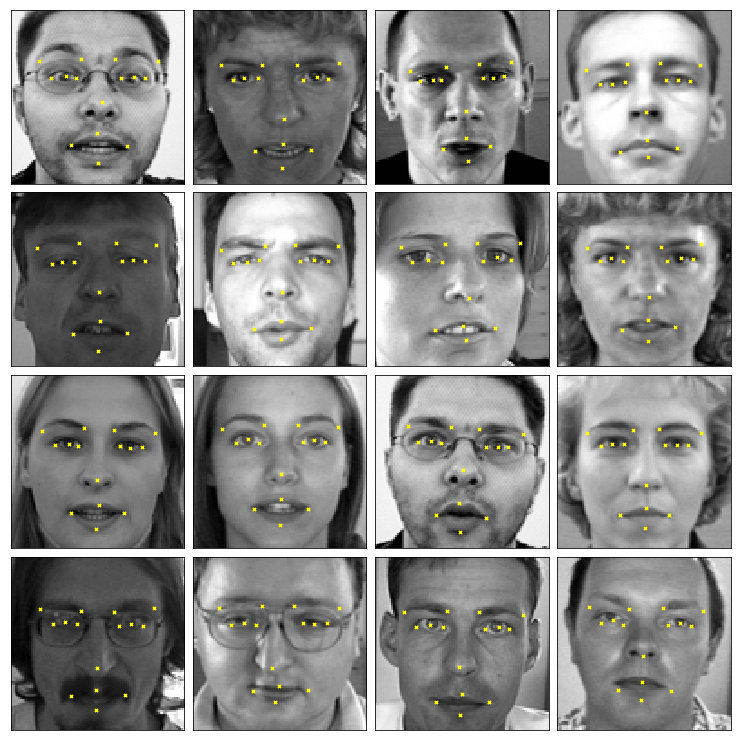

In [36]:
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    axis = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    plot_sample(X_test[i], y_pred2[i], axis)

plt.show()

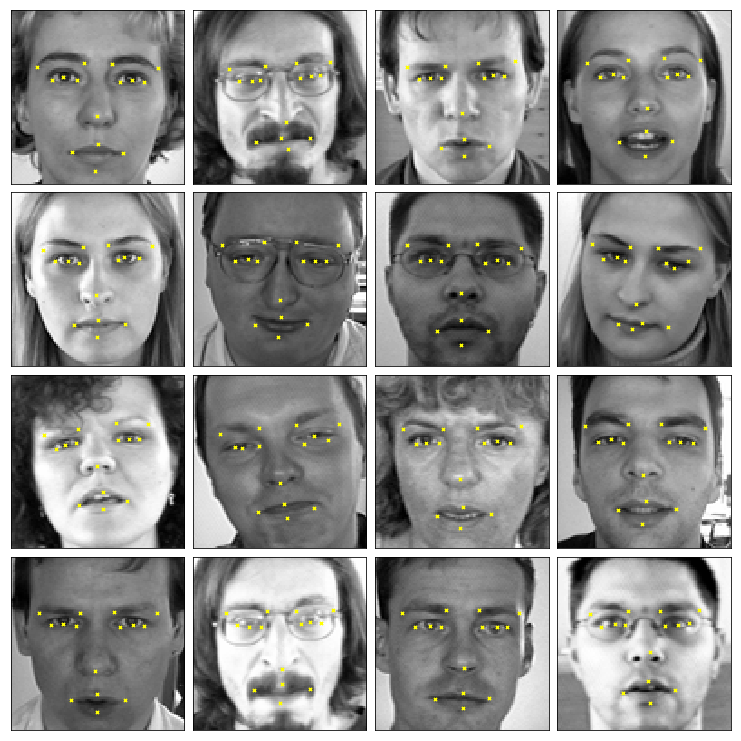

In [37]:
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    axis = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    plot_sample(X_test[i+16], y_pred2[i+16], axis)

plt.show()

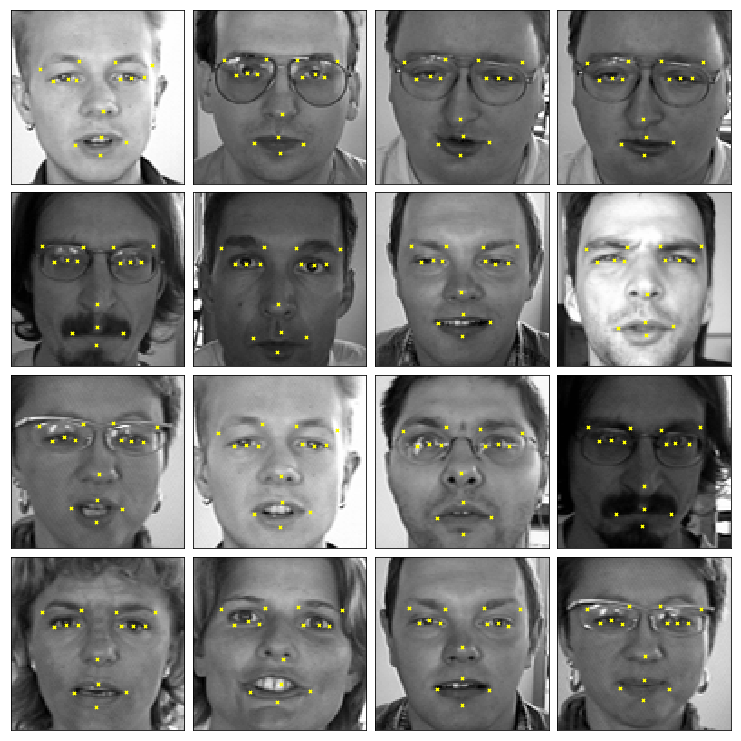

In [38]:
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    axis = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    plot_sample(X_test[i+80], y_pred2[i+80], axis)

plt.show()

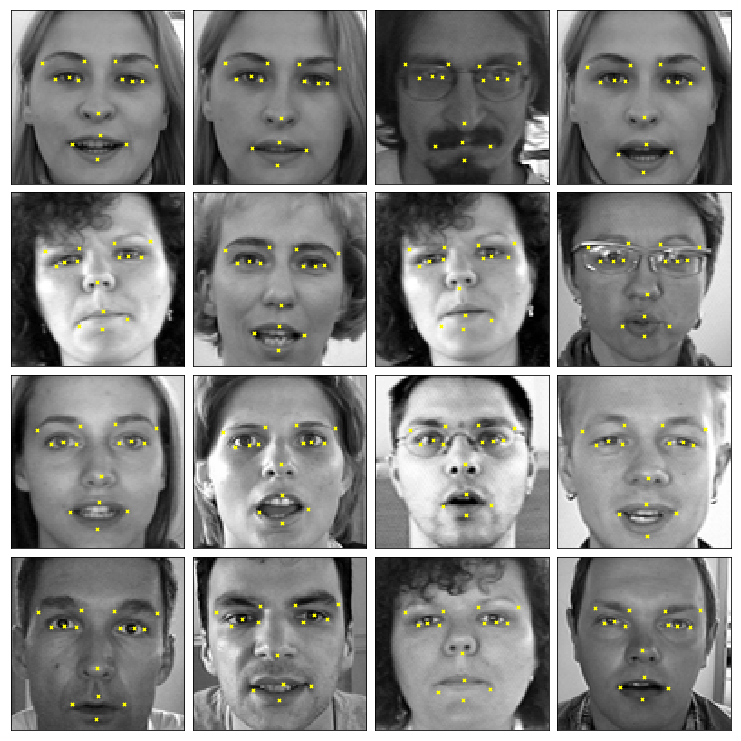

In [39]:
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    axis = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    plot_sample(X_test[i+200], y_pred2[i+200], axis)

plt.show()